# LightGBM Model - Using Feature-Engineered Data

Trains a LightGBM classifier on the feature-engineered train/test CSVs and writes a submission file.


In [15]:
# Imports
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)



## 1) Load feature-engineered data


In [16]:
DATA_DIR = '../data/processed'
TRAIN_FE = os.path.join(DATA_DIR, 'train_fe.csv')
TEST_FE = os.path.join(DATA_DIR, 'test_fe.csv')
RESULTS_PATH = '../results/lgbm_fe_submission_v2.csv'

train_df = pd.read_csv(TRAIN_FE)
test_df = pd.read_csv(TEST_FE)

print(train_df.shape, test_df.shape)
train_df.head()


(593994, 22) (254569, 21)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,grade,subgrade_num,grade_score,has_stable_income,is_unemployed,loan_to_income_ratio,estimated_monthly_payment,payment_burden,risk_score
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0,C,3,4,1,0,0.086094,28.802918,0.011769,0.2207
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0,D,3,3,1,0,0.207757,49.452377,0.026842,0.2952
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0,C,5,4,1,0,0.343080,138.308553,0.033485,0.1946
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0,F,1,1,1,0,0.099929,62.823273,0.016089,0.2260
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0,D,1,3,1,0,0.477883,103.669192,0.048792,0.1551


## 2) Define features


In [17]:
target = 'loan_paid_back'
drop_cols = ['id', target]

# Categorical features (LightGBM can take raw categories)
categorical_features = [
    'gender', 'marital_status', 'education_level', 'employment_status',
    'loan_purpose', 'grade', 'grade_subgrade'
]

# Numerical features (including engineered)
# Trim out weaker ratios for this run
numerical_features = [
    'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate',
    'subgrade_num', 'grade_score', 'has_stable_income', 'is_unemployed',
    'risk_score'
]

feature_cols = categorical_features + numerical_features

X_train = train_df[feature_cols].copy()
y_train = train_df[target].copy()
X_test = test_df[feature_cols].copy()

print("Features:", len(feature_cols))
print("Categorical:", categorical_features)
print("Numerical (first 5):", numerical_features[:5])


Features: 17
Categorical: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade', 'grade_subgrade']
Numerical (first 5): ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']


## 3) Prepare categoricals


In [18]:
# Cast categoricals to category dtype
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

categorical_feature_indices = [X_train.columns.get_loc(c) for c in categorical_features]
print("Categorical feature indices:", categorical_feature_indices)
print("Sample dtypes:\n", X_train.dtypes.head())


Categorical feature indices: [0, 1, 2, 3, 4, 5, 6]
Sample dtypes:
 gender               category
marital_status       category
education_level      category
employment_status    category
loan_purpose         category
dtype: object


## 4) Train LightGBM (quick settings)


In [19]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 63,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'verbose': -1,
    'random_state': 42,
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
}

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

cv_scores = []
test_preds = np.zeros(len(X_test))

print(f"Scale_pos_weight: {params['scale_pos_weight']:.4f}")
print(f"Starting {n_splits}-fold CV...")

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    # Ensure categories remain category dtype
    for col in categorical_features:
        X_tr[col] = X_tr[col].astype('category')
        X_val[col] = X_val[col].astype('category')
    
    dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_feature_indices, free_raw_data=False)
    dval = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_feature_indices, free_raw_data=False)
    
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'valid'],
        num_boost_round=500,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=100)
        ]
    )
    
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    val_auc = roc_auc_score(y_val, val_pred)
    cv_scores.append(val_auc)
    print(f"Fold {fold} AUC: {val_auc:.6f}")
    
    test_preds += test_pred / n_splits

print("\nCV mean AUC:", np.mean(cv_scores))
print("CV std AUC:", np.std(cv_scores))


Scale_pos_weight: 0.2518
Starting 5-fold CV...
[100]	train's auc: 0.922299	valid's auc: 0.920609
[200]	train's auc: 0.927438	valid's auc: 0.921916
[300]	train's auc: 0.931435	valid's auc: 0.922381
Fold 1 AUC: 0.922400
[100]	train's auc: 0.922758	valid's auc: 0.920187
[200]	train's auc: 0.927639	valid's auc: 0.921246
[300]	train's auc: 0.931663	valid's auc: 0.921818
[400]	train's auc: 0.934992	valid's auc: 0.921849
Fold 2 AUC: 0.921913
[100]	train's auc: 0.923213	valid's auc: 0.918964
[200]	train's auc: 0.928115	valid's auc: 0.919945
[300]	train's auc: 0.932063	valid's auc: 0.9205
[400]	train's auc: 0.93546	valid's auc: 0.920627
[500]	train's auc: 0.938703	valid's auc: 0.920815
Fold 3 AUC: 0.920837
[100]	train's auc: 0.922994	valid's auc: 0.919686
[200]	train's auc: 0.927928	valid's auc: 0.9209
[300]	train's auc: 0.931849	valid's auc: 0.921387
[400]	train's auc: 0.935262	valid's auc: 0.921428
Fold 4 AUC: 0.921452
[100]	train's auc: 0.922979	valid's auc: 0.919222
[200]	train's auc: 0.928

## 5) Feature importance


                 feature     importance
14     has_stable_income  573321.763143
16            risk_score  151589.318596
8   debt_to_income_ratio  136045.288497
9           credit_score  114745.961091
3      employment_status   38598.346608
15         is_unemployed   19251.810669
13           grade_score   15551.764011
10           loan_amount   15179.379414
7          annual_income   13547.894925
6         grade_subgrade   12133.958544
11         interest_rate   12109.628875
4           loan_purpose    2620.417271
2        education_level    1418.314231
12          subgrade_num    1095.111289
0                 gender     812.756520
1         marital_status     325.344470
5                  grade      11.140990


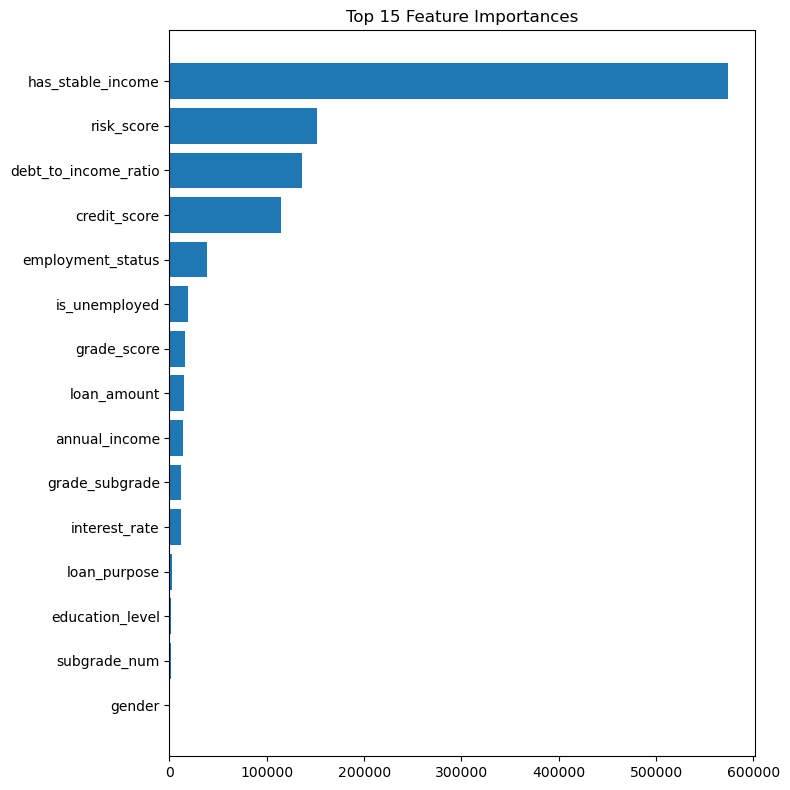

In [20]:
if 'model' in locals():
    fi = pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(importance_type='gain')
    }).sort_values('importance', ascending=False)
    print(fi.head(20))
    
    import matplotlib.pyplot as plt
    topk = fi.head(15)
    plt.figure(figsize=(8, 8))
    plt.barh(range(len(topk)), topk['importance'])
    plt.yticks(range(len(topk)), topk['feature'])
    plt.gca().invert_yaxis()
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()
else:
    print("Train the model cell first.")


## 6) Train final model on full dataset and save


In [22]:
# Train final model on full training data
print("Training final model on full dataset...")

# Ensure categoricals are category dtype
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')

dtrain_full = lgb.Dataset(
    X_train, 
    label=y_train, 
    categorical_feature=categorical_feature_indices,
    free_raw_data=False
)

# Use same params but train without early stopping (no validation set available)
# Use average best iteration from CV as reference
final_params = params.copy()
# Train with a reasonable number of rounds based on CV results
final_model = lgb.train(
    final_params,
    dtrain_full,
    num_boost_round=400,  # Fixed rounds, no early stopping needed
    callbacks=[
        lgb.log_evaluation(period=100)
    ]
)

# Save model
MODEL_DIR = '../models'
MODEL_PATH = os.path.join(MODEL_DIR, 'lgbm_loan_model.txt')
os.makedirs(MODEL_DIR, exist_ok=True)
final_model.save_model(MODEL_PATH)
print(f"Model saved to: {MODEL_PATH}")

# Generate predictions with final model
test_preds_final = final_model.predict(X_test)
print(f"Final model trained with {final_model.num_trees()} trees")


Training final model on full dataset...
Model saved to: ../models/lgbm_loan_model.txt
Final model trained with 400 trees


## 7) Save submission


In [23]:
# Use CV-averaged predictions (usually better) or final model predictions
# Option 1: Use CV-averaged predictions (what we did before)
submission = pd.DataFrame({
    'id': test_df['id'],
    'loan_paid_back': test_preds  # CV-averaged
})

# Option 2: Use final model predictions (uncomment if preferred)
# submission = pd.DataFrame({
#     'id': test_df['id'],
#     'loan_paid_back': test_preds_final
# })

os.makedirs('../results', exist_ok=True)
submission.to_csv(RESULTS_PATH, index=False)

print("Saved submission to:", RESULTS_PATH)
print(submission.head())
print("\nSubmission statistics:")
print(submission['loan_paid_back'].describe())


Saved submission to: ../results/lgbm_fe_submission_v2.csv
       id  loan_paid_back
0  593994        0.741852
1  593995        0.932589
2  593996        0.193195
3  593997        0.767991
4  593998        0.873857

Submission statistics:
count    254569.000000
mean          0.671122
std           0.314722
min           0.000537
25%           0.508891
50%           0.783172
75%           0.927219
max           0.999117
Name: loan_paid_back, dtype: float64
